# Making a connectivity matrix from the Fruit Fly connectome

Using Janelia's data [here](https://storage.cloud.google.com/hemibrain/v1.2/exported-traced-adjacencies-v1.2.tar.gz) (explained [here](https://dvid.io/blog/release-v1.2/#downloads))

We get a list of all neuron names, types and ids, and then a list of the number of synapses from one neuron to another.

We can use these to make a connectivity matrix (based on the number of synapses) for the neurons in the central complex circuit (PEN, PEG, EPG, Delta7)

In [1]:
import pandas as pd
import numpy as np
import numpy.lib.stride_tricks
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')
plt.rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
plt.rc('text', usetex=True)
np.random.seed(7) # seed so plots are repeatable
%matplotlib inline
# need the %matplotlib inline for the following to work
plt.rc('figure', figsize = [10,6]) # paper figures should be width 10 (full linewidth) to have nicely readable text

In [2]:
neurons = pd.read_csv('janelia-data/traced-neurons.csv')
connections = pd.read_csv('janelia-data/traced-total-connections.csv')
neurons

,bodyId,type,instance
0,200326126,CL141,CL141_L
1,202916528,FS4C,FS4C(FQ12)_C4_R
2,203253072,FS4A,FS4A(AB)(FQ12)_C3_R
3,203253253,SMP505,SMP505(PDM22)_L
4,203257652,FS4C,FS4C(FQ12)_C6_R
...,...,...,...
21734,7112579856,LC20,LC20
21735,7112615127,AVLP335,AVLP335_R
21736,7112617294,AVLP331,AVLP331_R
21737,7112622044,LAL137,LAL137(PVL05)_L


In [3]:
pen1 = neurons[neurons.type == 'PEN_a(PEN1)'].sort_values('instance')
pen2 = neurons[neurons.type == 'PEN_b(PEN2)'].sort_values('instance')
# sort pen1 and pen2 together
pen = pd.concat((pen1, pen2)).loc[pd.concat((pen1, pen2)).instance.apply(lambda x: x[-2:]).sort_values().index]
peg = neurons[neurons.type == 'PEG'].sort_values('instance')
epg = neurons[neurons.type == 'EPG'].sort_values('instance')
d7 = neurons[neurons.type == 'Delta7'].sort_values('instance')

# flip the sorting of neurons on right side so the order becomes (ie. L1, L2, ..., L9, R9, ..., R2, R1)
pen = pen.sort_values(by='instance', key=lambda column: column.apply(lambda instance: int(instance[-1]) if instance[-2] == 'L' else 100-int(instance[-1])))
peg = peg.sort_values(by='instance', key=lambda column: column.apply(lambda instance: int(instance[-1]) if instance[-2] == 'L' else 100-int(instance[-1])))
epg = epg.sort_values(by='instance', key=lambda column: column.apply(lambda instance: int(instance[-1]) if instance[-2] == 'L' else 100-int(instance[-1])))

ids = list(pd.concat((pen.bodyId, peg.bodyId, epg.bodyId, d7.bodyId)))
ids_set = set(ids) # faster to call `in` for a set

In [4]:
# get the rows of the connections table that we care about
connections_subset = connections.iloc[[pre_id in ids_set and post_id in ids_set for pre_id, post_id in zip(connections.bodyId_pre, connections.bodyId_post)]]
connections_subset

,bodyId_pre,bodyId_post,weight
229804,387364605,789126240,1
229810,387364605,1065409934,1
229813,387364605,912545106,3
229815,387364605,1035045015,1
229818,387364605,911565419,1
...,...,...,...
3459269,5813080838,5813056953,25
3459273,5813080838,1220576923,8
3459275,5813080838,973566036,43
3459277,5813080838,911578496,35


In [5]:
# convert the table to a connectivity matrix [pre,post]
connectivity_matrix = np.zeros((len(ids),len(ids)))

for pre_id, post_id, weight in connections_subset.itertuples(index=False):
	connectivity_matrix[ids.index(pre_id), ids.index(post_id)] = weight

np.save('connectivity_matrix_drosophila_janelia', connectivity_matrix)

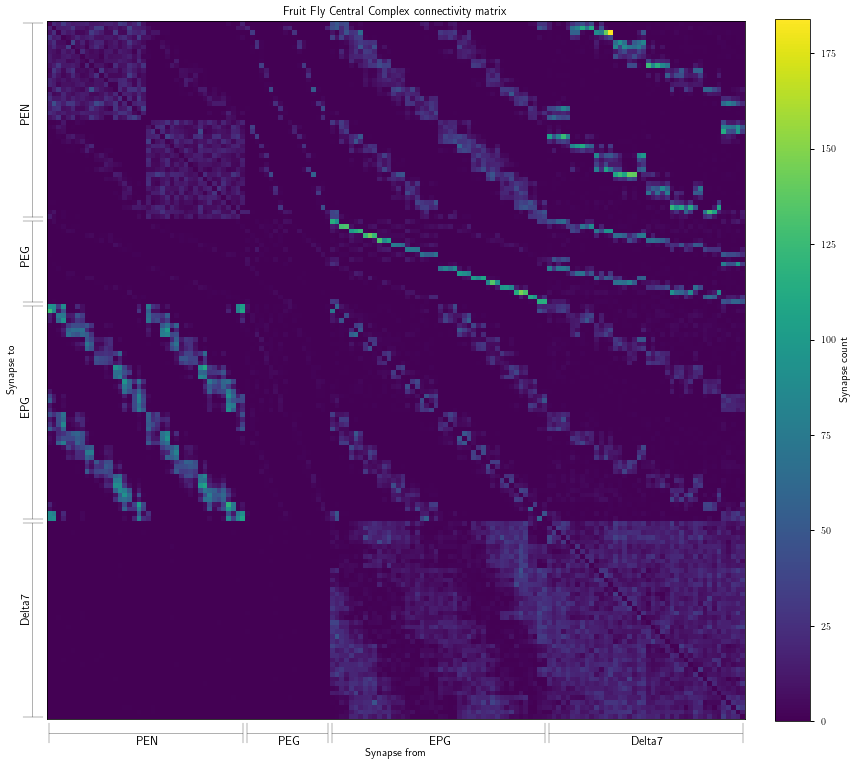

In [6]:
plt.figure(figsize=(12,12))
im = plt.imshow(connectivity_matrix.T)
plt.xlabel('\n\nSynapse from')
plt.ylabel('Synapse to\n\n')
plt.title('Fruit Fly Central Complex connectivity matrix')
plt.xticks([])
plt.yticks([])

type_borders = np.cumsum([0,len(pen1)+len(pen2),len(peg),len(epg),len(d7)])

for start,stop,type in zip(type_borders[:-1], type_borders[1:],['PEN','PEG','EPG','Delta7']):
	bar_distance = 3
	plt.annotate('',xy=(start-.5,plt.ylim()[0]+bar_distance),xytext=(stop-.5,plt.ylim()[0]+bar_distance), arrowprops=dict(arrowstyle='|-|',facecolor='red'), annotation_clip=False)
	plt.annotate('',xy=(plt.xlim()[0]-bar_distance,start-.5),xytext=(plt.xlim()[0]-bar_distance,stop-.5), arrowprops=dict(arrowstyle='|-|',facecolor='red'), annotation_clip=False)

	plt.annotate(type,xy=((start+stop)/2,plt.ylim()[0]+bar_distance+2.5), annotation_clip=False, fontsize=12, horizontalalignment='center')
	plt.annotate(type,xy=(plt.xlim()[0]-bar_distance-1.5,(start+stop)/2), annotation_clip=False, fontsize=12, horizontalalignment='center', rotation=90)

plt.colorbar(im, fraction=0.046, pad=0.04, label='Synapse count')
plt.tight_layout()
plt.show()

## Group neurons in the same glomerulus

Looking for example at the EPG neurons (instance column), we can see that there are multiple neurons in each of the glomeruli (L1, R4, ...).

We can group these to simplify the connectivity matrix, assuming the same type of neurons in the same glomerulus perform a similar function

In [7]:
epg

,bodyId,type,instance
13392,1447576662,EPG,EPG(PB08)_L1
3381,572870540,EPG,EPG(PB08)_L1
7423,912545106,EPG,EPG(PB08)_L2
4907,697001770,EPG,EPG(PB08)_L2
5615,758419409,EPG,EPG(PB08)_L3
1277,387364605,EPG,EPG(PB08)_L3
1935,449438847,EPG,EPG(PB08)_L3
4172,634962055,EPG,EPG(PB08)_L4
4512,665314820,EPG,EPG(PB08)_L4
19562,5813022281,EPG,EPG(PB08)_L4


In [8]:
# want to create groups based on the unique instances of each type of neuron, preserving the ordering we used above
all_neuron_instances = pd.concat((
	pen.instance.apply(lambda x: f'PEN_{x[-2:]}'),
	peg.instance.apply(lambda x: f'PEG_{x[-2:]}'),
	epg.instance.apply(lambda x: f'EPG_{x[-2:]}'),
	d7.instance.apply(lambda x: f'D7_{x.split("_")[1][:2]}') # note: D7 mixes some slightly different neurons eg. L4R5 and L4R6...
))
# make a list containing the index of the group to which each neuron belongs (unique L# or R# values for each neuron type)
neuron_groups, unique_indices = np.unique(all_neuron_instances, return_index=True)
neuron_groups = list(neuron_groups[np.argsort(unique_indices)])
neuron_group_indices = [neuron_groups.index(instance) for instance in all_neuron_instances]

In [9]:
# create the grouped connectivity_matrix
connectivity_matrix_grouped = np.zeros((len(neuron_groups), len(neuron_groups)))

for pre_id, post_id, weight in connections_subset.itertuples(index=False):
	connectivity_matrix_grouped[neuron_group_indices[ids.index(pre_id)], neuron_group_indices[ids.index(post_id)]] += weight

np.save('connectivity_matrix_drosophila_janelia_grouped', connectivity_matrix_grouped)

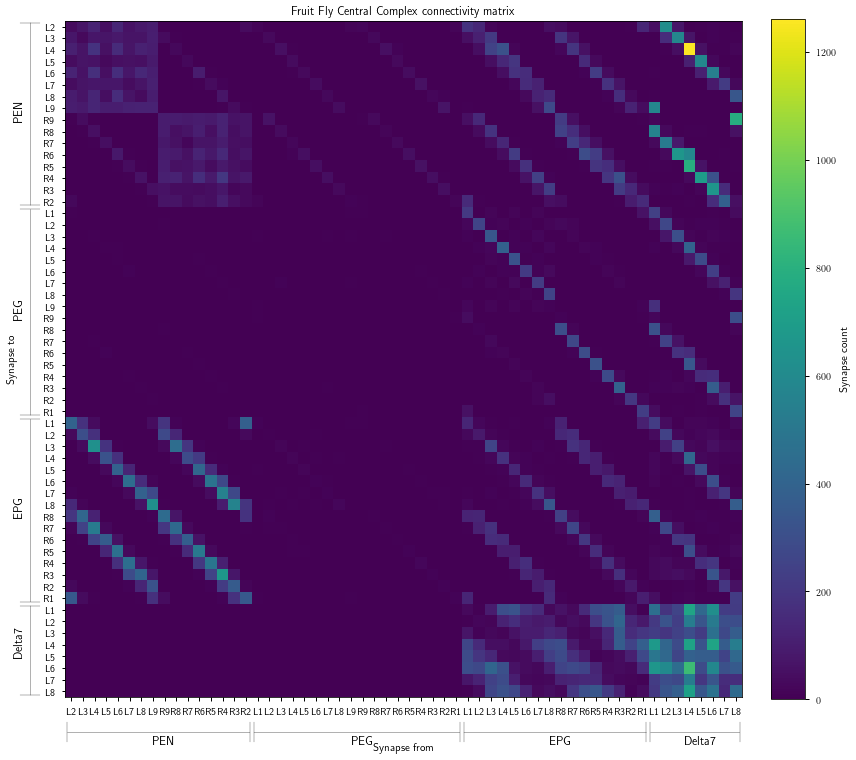

In [10]:
plt.figure(figsize=(12,12))
im = plt.imshow(connectivity_matrix_grouped.T)
plt.xlabel('\n\nSynapse from')
plt.ylabel('Synapse to\n\n')
plt.title('Fruit Fly Central Complex connectivity matrix')
plt.xticks(np.arange(len(neuron_groups)), [s.split('_')[1] for s in neuron_groups])
plt.yticks(np.arange(len(neuron_groups)), [s.split('_')[1] for s in neuron_groups])

type_borders = np.cumsum([0,16,18,16,8])

for start,stop,type in zip(type_borders[:-1], type_borders[1:],['PEN','PEG','EPG','Delta7']):
	bar_distance = 3
	plt.annotate('',xy=(start-.5,plt.ylim()[0]+bar_distance),xytext=(stop-.5,plt.ylim()[0]+bar_distance), arrowprops=dict(arrowstyle='|-|',facecolor='red'), annotation_clip=False)
	plt.annotate('',xy=(plt.xlim()[0]-bar_distance,start-.5),xytext=(plt.xlim()[0]-bar_distance,stop-.5), arrowprops=dict(arrowstyle='|-|',facecolor='red'), annotation_clip=False)

	plt.annotate(type,xy=((start+stop)/2,plt.ylim()[0]+bar_distance+1), annotation_clip=False, fontsize=12, horizontalalignment='center')
	plt.annotate(type,xy=(plt.xlim()[0]-bar_distance-1,(start+stop)/2), annotation_clip=False, fontsize=12, horizontalalignment='center', rotation=90)

plt.colorbar(im, fraction=0.046, pad=0.04, label='Synapse count')
plt.tight_layout()
plt.show()